## Small model to predict compute time from parameters of dense/convolutional layer

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
import time
import shutil

from performance_prediction_model import Model
import dataprep
import os

### Import data as pd dataframe
#### Data should contain parameters and max/median/min/std of time

In [159]:
model_name = 'GCP_P100'

try:
    os.mkdir('models/%s' %model_name)
except:
    pass 

useData = 'Conv' # 'Dense' or 'Conv'
# useData = 'Dense'

In [160]:
if useData == 'Conv':
    df = pd.read_pickle('data/Data_convolution_%s.pkl' %model_name)
    scaler_filename = ("models/%s/scaler_Conv.save" %model_name)
elif useData == 'Dense':
    df = pd.read_pickle('data/Data_dense_%s.pkl' %model_name)
    scaler_filename = ("models/%s/scaler_Dense.save" %model_name)
else:
    print('useData must be Dense or Conv, currently is %s' %useData)

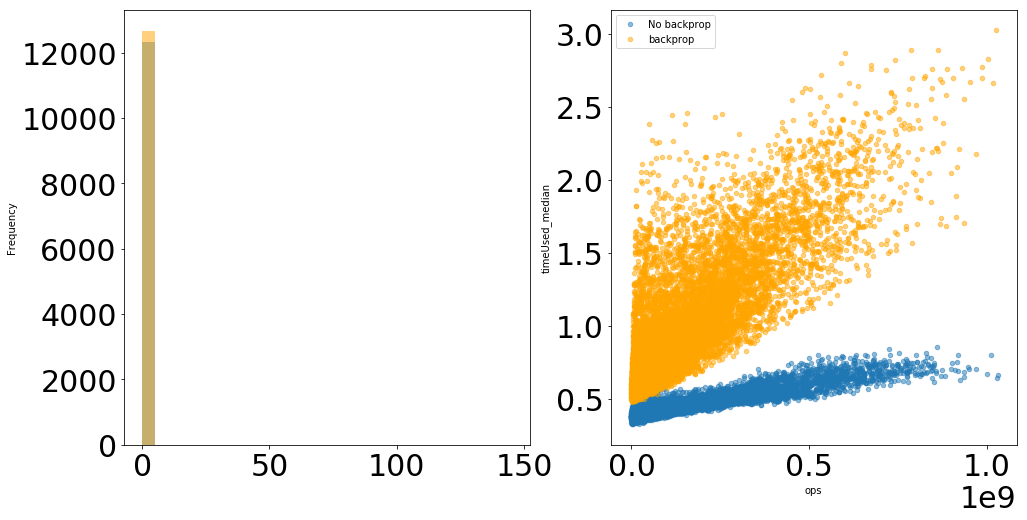

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16,8])

df[df['opt_None']==1]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5)
df[df['opt_None']==0]['timeUsed_median'].plot.hist(bins=np.arange(0,150,5), ax=axes[0], alpha=.5, color='orange')

df[df['opt_None']==1].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, label='No backprop')
df[df['opt_None']==0].plot.scatter(x='ops', y='timeUsed_median', ax=axes[1], alpha=.5, color='orange', label='backprop')

plt.show()

In [162]:
if useData == 'Dense':
    model_name = '%s_dense' %model_name

In [163]:
# # Only forward pass
# df = df[df['opt_None']==1]
# model_name = '%s_FW'%model_name
# scaler_filename = ("scaler_%s_Conv.save" %model_name)

### Generate train, test and validation datasets (80%,10%,10%)
#### Normalise data, generate train, test, validation dataset
#### Use median of time as target parameter

In [164]:
split=[.8,.1,.1]
if model_name == 'all' or model_name[0:3] == 'no_':
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel','channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
#                       'ops','memory_weights','memory_in','memory_out',
                      'bandwidth','cores','clock'
                     ]
else:
    data_cols_conv = ['batchsize','elements_matrix','elements_kernel','channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid'
#                       'ops','memory_weights','memory_in','memory_out'
                     ]
    
data_cols_dense = ['batchsize','dim_input','dim_output',
                   'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                   'act_relu','act_tanh','act_sigmoid']


if useData == 'Conv':
    data_cols = data_cols_conv
elif useData == 'Dense':
    data_cols = data_cols_dense

In [165]:
data, time, train, test, validation, scaler = dataprep.data_preprocess(df,data_cols,split)
joblib.dump(scaler, scaler_filename) 

Size of train dataset: 20000 
Size of test dataset: 2500 
Size of validation dataset: 2500


/Users/djustus/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


['models/GCP_P100/scaler_Dense.save']

### Define model

In [166]:
if model_name == 'all' or model_name[0:3] == 'no_':
    num_neurons = [32,64,128,128,128,128]
else:
    num_neurons = [32,64,128,128]
    
lr_initial = 0.1
lr_decay_step = 40

In [167]:
tf.reset_default_graph()
data_dim = data['Train'].shape[1]

inputs = tf.placeholder(tf.float32, shape=(None, data_dim), name='model_input')
targets = tf.placeholder(tf.float32, shape=(None), name='model_targets')
learning_rate = tf.placeholder(tf.float32, shape=[])
reg_constant = .00001
dropout_rate = 0.2
batch_size = 128

#### Remove checkpoints and tb output

In [168]:
try:
    folder = ('checkpoints/%s' %model_name)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        os.remove(file_path)

    folder = ('graphs/prediction/test/%s' %model_name)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)

    folder = ('graphs/prediction/train/%s' %model_name)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file) 
        os.remove(file_path)
        
    print('Checkpoints cleared')
except:
    print('Nothing to delete')
    

Nothing to delete


In [169]:
model = Model(inputs,targets,learning_rate,reg_constant,dropout_rate,
              num_neurons,lr_initial,lr_decay_step,batch_size,model_name)

In [170]:
model.prediction
model.train_op

<tf.Operation 'Adam' type=AssignAdd>

### Run model, generate plots
##### Checkpoints in ./Checkpoint, tb graphs and summaries in ./graphs

In [171]:
model.train(data['Train'],time['Train'],data['Test'],time['Test'],300)

Epoch 0: Train loss 0.018, Test loss 0.005
Epoch 10: Train loss 0.003, Test loss 0.002
Epoch 20: Train loss 0.002, Test loss 0.002
Epoch 30: Train loss 0.002, Test loss 0.002
Epoch 40: Train loss 0.002, Test loss 0.002
Epoch 50: Train loss 0.002, Test loss 0.001
Epoch 60: Train loss 0.002, Test loss 0.001
Epoch 70: Train loss 0.002, Test loss 0.001
Epoch 80: Train loss 0.002, Test loss 0.001
Epoch 90: Train loss 0.002, Test loss 0.001
Epoch 100: Train loss 0.002, Test loss 0.001
Epoch 110: Train loss 0.002, Test loss 0.001
Epoch 120: Train loss 0.002, Test loss 0.001
Epoch 130: Train loss 0.002, Test loss 0.001
Epoch 140: Train loss 0.002, Test loss 0.001
Epoch 150: Train loss 0.002, Test loss 0.001
Epoch 160: Train loss 0.002, Test loss 0.001
Epoch 170: Train loss 0.002, Test loss 0.001
Epoch 180: Train loss 0.002, Test loss 0.001
Epoch 190: Train loss 0.002, Test loss 0.001
Epoch 200: Train loss 0.002, Test loss 0.001
Epoch 210: Train loss 0.002, Test loss 0.001
Epoch 220: Train loss

In [172]:
saver = tf.train.Saver()
try:
    folder = ('models/%s/saved_model' %model_name)
    shutil.rmtree(folder)
except:
    pass
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    tf.saved_model.simple_save(
            sess,
            'models/%s/saved_model' %model_name,
            inputs={'model_input': inputs,'model_istraining': model.istraining},
            outputs={'model_prediction': model.prediction})

INFO:tensorflow:Restoring parameters from checkpoints/GCP_P100_dense/prediction-299
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/GCP_P100_dense/saved_model/saved_model.pb


INFO:tensorflow:Restoring parameters from checkpoints/GCP_P100_dense/prediction-299


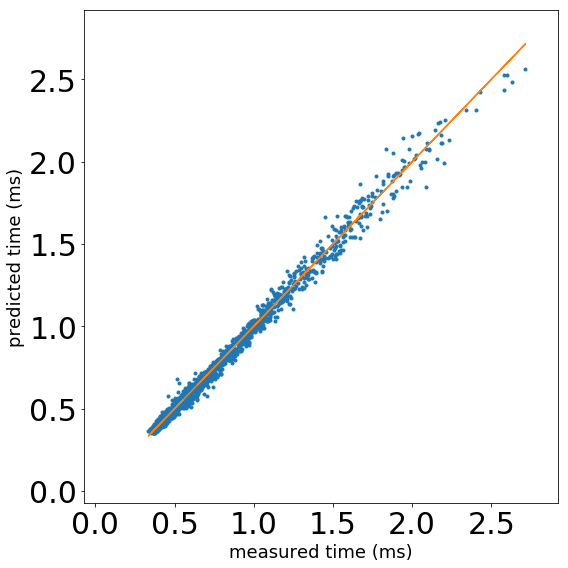

RMS test error = 0.0335 ms


In [173]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
    
    test_prediction, test_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Test'], 
                       model.targets: time['Test'],
                       model.istraining: False}) 
    
RMS_test_error=np.sqrt(np.mean((time['Test']-test_prediction)**2))

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Test'],test_prediction,'.')
ax.plot(time['Test'],time['Test'],2)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('RMS validation error = %.3g ms' %(RMS_validation_error),fontsize=16)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

plt.xlabel('measured time (ms)',fontsize=18)
plt.ylabel('predicted time (ms)',fontsize=18)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()

# if useData == 'Conv':
#     plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
# elif useData == 'Dense':
#     plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS test error = %.3g ms' %(RMS_test_error))

### STOP here - validation data set

INFO:tensorflow:Restoring parameters from checkpoints/GCP_P100_dense/prediction-299


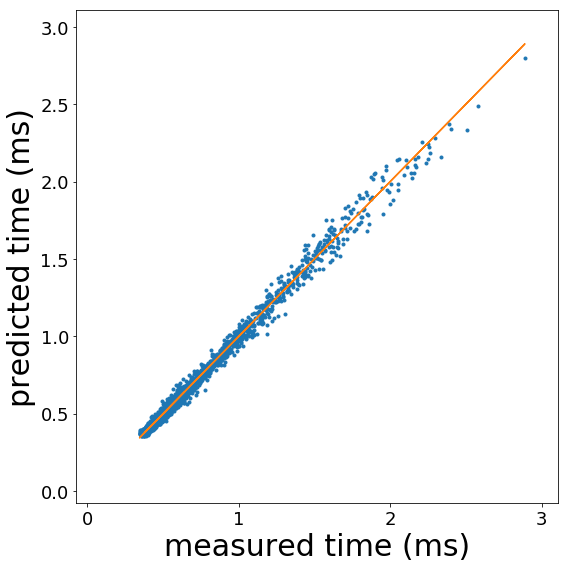

RMS validation error = 0.0329 ms


In [174]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/%s/checkpoint' %model_name))
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    v = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
    
    validation_prediction, validation_loss = sess.run(
            [model.prediction,model.loss], 
            feed_dict={model.inputs: data['Validation'], 
                       model.targets: time['Validation'],
                       model.istraining: False}) 
    
RMS_validation_error=np.sqrt(np.mean((time['Validation']-validation_prediction)**2))

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],validation_prediction,'.')
ax.plot(time['Validation'],time['Validation'],2)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_title('RMS validation error = %.3g ms' %(RMS_validation_error),fontsize=16)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()

if useData == 'Conv':
    plt.savefig('figures/Validation_%s_conv.png' %model_name, dpi=300)
elif useData == 'Dense':
    plt.savefig('figures/Validation_%s_fc.png' %model_name, dpi=300)

plt.show()
print('RMS validation error = %.3g ms' %(RMS_validation_error))

## Build a linear regression as comparison

In [151]:
df_validation = df.iloc[validation]
df_train = df.iloc[train]

In [152]:
linreg = linear_model.LinearRegression()

In [153]:
x_train = df_train[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values   
y_train = df_train['timeUsed_median'].values   # time

x_valid = df_validation[['batchsize','elements_matrix','elements_kernel',
                'channels_in','channels_out','padding','strides','use_bias','ops']].values
y_valid = df_validation['timeUsed_median'].values   # time

In [154]:
linreg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [155]:
lp = linreg.predict(x_valid)

In [156]:
linreg.coef_

array([ 5.42956713e-02,  2.00183723e-05,  2.44867254e-02,  5.49083514e-04,
        2.34092073e-04,  3.67725528e-01, -8.13440522e-01,  1.70995728e-01,
        1.53928997e-10])

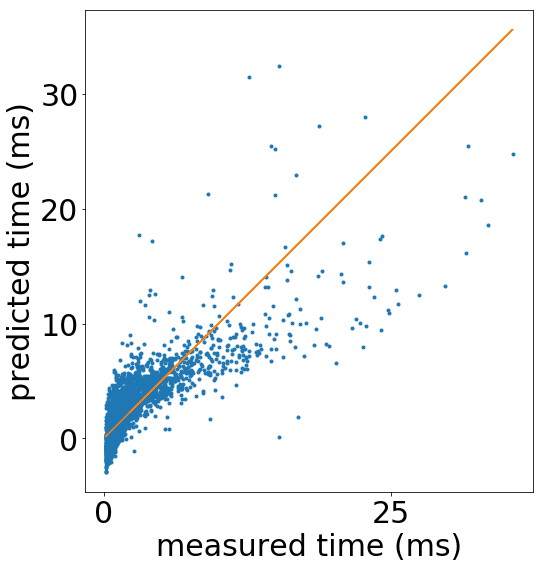

In [157]:
labels = [.2,.3,.4,.5,1]

RMS_vadiation_error=np.sqrt(np.mean((y_valid-lp)**2))
fig,ax = plt.subplots(1,1,figsize=[8,8])

ax.plot(y_valid,lp,'.')

ax.plot(y_valid,y_valid)
#ax.set_title('RMS validation error = %.3g ms' %(RMS_vadiation_error),fontsize=16)


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.xlabel('measured time (ms)',fontsize=30)
plt.ylabel('predicted time (ms)',fontsize=30)

ax.xaxis.set_ticks([0,25,50,75,100,120])

plt.tight_layout()
plt.axis('equal')


if useData == 'Conv':
    plt.savefig('figures/Validation_%s_conv_linearreg.png' %model_name, dpi=300)
elif useData == 'Dense':
    plt.savefig('figures/Validation_%s_fc_linearreg.png' %model_name, dpi=300)

plt.show()

In [158]:
RMS_vadiation_error

2.4175696227075365